In [38]:
#Importamos el GitHub
! git clone https://github.com/Santiago-Porras/Bavaria_Colombia

fatal: destination path 'Bavaria_Colombia' already exists and is not an empty directory.


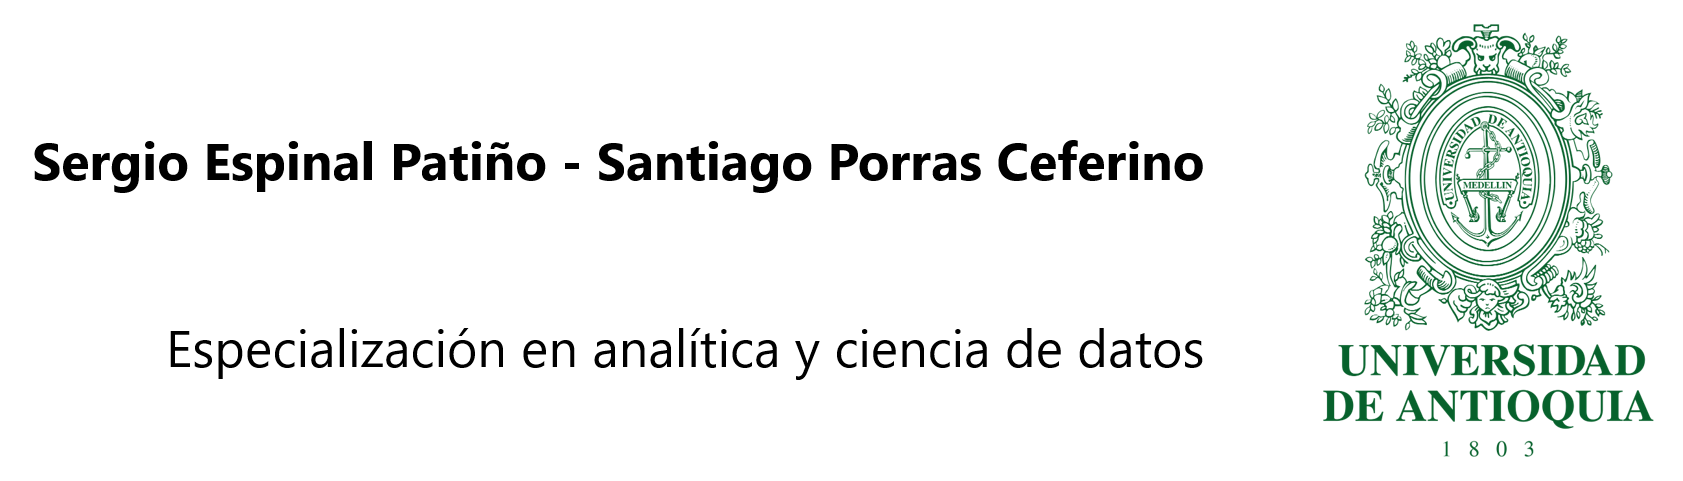

In [39]:
from IPython.display import Image
Image("/content/Bavaria_Colombia/img/Imagen1.png")

# Reto Colombia
En Bavaria quieren encontrar la mejor estrategia de impulso, mantenimiento o frenado, de un listado de marcas establecido, con el objetivo de ofrecer el mejor portafolio a los puntos de venta/zonas dependiendo de sus características e historial de compra.​

## Explicación Dataset

- BaseConsolidada.csv = Tabla de clientes con las características de su punto de venta, ubicación e histórico de compra

```
Cliente : Id del Establecimiento (Llave primaria)
Regional2: Región donde se encuentra ubicado (Conjunto de departamentos)
Gerencia2: Gerencia que le distribuye el producto (Conjunto de 1, 2 o mas ciudades)
SubCanal2: Tipo de establecimiento: (Tienda, Bar, etc)
Categoria: Variable definida por AB-Inbev para calificar la importancia de un establecimiento dada su compra histórica.
Nevera: Variable dummie que me permite ver si el establecimiento tiene o no una nevera en su punto de venta.
Año: Año en el que se realiza la compra
Mes: Mes en el que se realiza la compra
Cliente: Id del establecimiento
SegmentoPrecio2: Categoría de la marca, dado el ingreso por litro a la compañía.
Marca2: Marca vendida
Cupo2: Tipo de envase de la marca vendida
CapacidadEnvase2: Capacidad en volumen, de la Marca2-Cupo2 vendido.
Volumen: Cantidad de volumen vendido de la Marca-Cupo2-CapacidadEnvase2
disc: Descuentos otorgados al establecimiento por la compra
nr: NetRevenue que dejó la venta a la compañía.
```

 ## ¿Qué construir?
El objetivo es encontrar la probabilidad de que un cliente compre cada una de las marcas dadas, con el fin de asignar la estrategia adecuada a cada uno de ellos.​

Para esto se creará un modelo que estimé dicha probabilidad para cada una de las 5 marcas que se van a listar.​

Ver el Brewing Data Cup:

* [Link](https://github.com/Santiago-Porras/Bavaria_Colombia)

# Cargue de librerias para trabajar:

In [40]:
#Importamos Librerías

#Python
from datetime import datetime, timedelta,date
import pandas as pd
import numpy as np
from numpy import mean
from datetime import datetime


#Otras
from __future__ import division
import warnings
warnings.filterwarnings("ignore")


#Gráficos
%matplotlib inline
import matplotlib.pyplot as plt
!pip install plotly
import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objects as go
import seaborn as sns


#Imbalanced-learn - Scikit Learn
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

#Scikit Learn
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn import tree
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#XgBoost para el Clasificador
import xgboost as xgb

In [41]:
#Descomprimimos el conjunto de datos:
!unrar x -Y "/content/Bavaria_Colombia/data/Base_Consolidada.rar" "/content/drive/path/output_folder/"

#Importamos el conjunto de datos:
base_nueva = pd.read_csv("/content/drive/path/output_folder/BaseConsolidada.csv")
base_nueva = base_nueva.fillna("")
base_nueva['Fecha'] = pd.to_datetime(base_nueva['Fecha'], format='%Y/%m/%d')


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Bavaria_Colombia/data/Base_Consolidada.rar

Extracting  /content/drive/path/output_folder/BaseConsolidada.csv          0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 

In [42]:
#Dividimos Histórico + 1 mes
baseHist = base_nueva[(base_nueva['Fecha'] <= datetime(2020,7,1))].reset_index(drop=True)
baseSigMes = base_nueva[(base_nueva['Fecha'] == datetime(2020,8,1))].reset_index(drop=True)
baseSeptiembre = base_nueva[(base_nueva['Fecha'] == datetime(2020,9,1))].reset_index(drop=True)
baseSeptiembre.to_excel("baseSeptiembre.xlsx")

#Alistamiento de base:

baseUsuarios = pd.DataFrame(baseHist['Cliente'].unique())
baseUsuarios.columns = ['Cliente']
baseSigMes_1Compra = baseSigMes.groupby('Cliente').Fecha.min().reset_index()
baseSigMes_1Compra.columns = ['Cliente','FechaProxCompra']
baseSigMes_1Compra.shape
FechaUltCompra = baseHist.groupby('Cliente').Fecha.max().reset_index()
FechaUltCompra.columns = ['Cliente','FechaUltCompra']
baseFechasCompra = pd.merge(FechaUltCompra,baseSigMes_1Compra,on='Cliente',how='left')
baseFechasCompra['DiasSigCompra'] = (baseFechasCompra['FechaProxCompra'] - baseFechasCompra['FechaUltCompra']).dt.days
baseUsuarios = pd.merge(baseUsuarios, baseFechasCompra[['Cliente','DiasSigCompra']],on='Cliente',how='left')

* Calcularemos el RFM del notebook principal. (Ver repositorio)

In [43]:
#Recencia

baseDiasRecencia = baseHist.groupby('Cliente').Fecha.max().reset_index()
baseDiasRecencia.columns = ['Cliente','FechaUltCompra']
baseDiasRecencia['Recencia'] = (baseDiasRecencia['FechaUltCompra'].max() - baseDiasRecencia['FechaUltCompra']).dt.days
baseUsuarios = pd.merge(baseUsuarios, baseDiasRecencia[['Cliente','Recencia']], on='Cliente')
baseRecenciaClust = baseUsuarios[['Recencia']]
distancias = []
rango = range(1,10)
for i in rango:
    grupos = KMeans(n_clusters=i, max_iter=100)
    grupos = grupos.fit(baseRecenciaClust)
    distancias.append(grupos.inertia_)
kmeans = KMeans(n_clusters=3)
kmeans.fit(baseUsuarios[['Recencia']])
baseUsuarios['RecenciaCluster'] = kmeans.predict(baseUsuarios[['Recencia']])
def OrdenCluster(nombreCluster, etiqueta,df,ascending):
    new_nombreCluster = 'new_' + nombreCluster
    clustOrdenados = df.groupby(nombreCluster)[etiqueta].mean().reset_index()
    clustOrdenados = clustOrdenados.sort_values(by=etiqueta,ascending=ascending).reset_index(drop=True)
    clustOrdenados['index'] = clustOrdenados.index
    ClustOrdenAsc = pd.merge(df,clustOrdenados[[nombreCluster,'index']], on=nombreCluster)
    ClustOrdenAsc = ClustOrdenAsc.drop([nombreCluster],axis=1)
    ClustOrdenAsc = ClustOrdenAsc.rename(columns={"index":nombreCluster})
    return ClustOrdenAsc
baseUsuarios = OrdenCluster('RecenciaCluster', 'Recencia',baseUsuarios,False)
baseUsuarios.groupby('RecenciaCluster')['Recencia'].describe()

#Frecuencia

baseFrecuencia = baseHist.groupby('Cliente').Fecha.count().reset_index()
baseFrecuencia.columns = ['Cliente','Frecuencia']
baseUsuarios = pd.merge(baseUsuarios, baseFrecuencia, on='Cliente')
baseFrecuenciaClust = baseUsuarios[['Frecuencia']]
distancias = []
rango = range(1,10)
for i in rango:
    grupos = KMeans(n_clusters=i, max_iter=100)
    grupos = grupos.fit(baseFrecuenciaClust)
    distancias.append(grupos.inertia_)
kmeans = KMeans(n_clusters=4)
kmeans.fit(baseUsuarios[['Frecuencia']])
baseUsuarios['FrecuenciaCluster'] = kmeans.predict(baseUsuarios[['Frecuencia']])
baseUsuarios = OrdenCluster('FrecuenciaCluster', 'Frecuencia',baseUsuarios,True)
baseUsuarios.groupby('FrecuenciaCluster')['Frecuencia'].describe()

# Monetización

baseHist['Monetizacion'] = baseHist['nr']
baseMonetizacion = baseHist.groupby('Cliente').Monetizacion.sum().reset_index()
baseUsuarios = pd.merge(baseUsuarios, baseMonetizacion, on='Cliente')
baseMonetizacionClust = baseUsuarios[['Monetizacion']]
distancias = []
rango = range(1,10)
for i in rango:
    grupos = KMeans(n_clusters=i, max_iter=100)
    grupos = grupos.fit(baseMonetizacionClust)
    distancias.append(grupos.inertia_)
kmeans = KMeans(n_clusters=4)
kmeans.fit(baseUsuarios[['Monetizacion']])
baseUsuarios['MonetizacionCluster'] = kmeans.predict(baseUsuarios[['Monetizacion']])
baseUsuarios = OrdenCluster('MonetizacionCluster', 'Monetizacion',baseUsuarios,True)
baseUsuarios.groupby('MonetizacionCluster')['Monetizacion'].describe()

# Segmentación general (Feature adicional):
baseUsuarios['ScoreGeneral']= baseUsuarios['RecenciaCluster'] + \
                              baseUsuarios['FrecuenciaCluster'] + \
                              baseUsuarios['MonetizacionCluster']
indicadoresGenerales = baseUsuarios.groupby('ScoreGeneral')['Recencia','Frecuencia','Monetizacion'].mean()

#Segmentamos y clasificamos:

baseUsuarios['Segmento'] = 'Valor-Bajo'
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==2,'Segmento'] = 'Valor-Medio' 
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==3,'Segmento'] = 'Valor-Alto' 
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==4,'Segmento'] = 'Valor-Alto' 
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==5,'Segmento'] = 'Valor-Alto' 
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==6,'Segmento'] = 'Valor-Medio' 


In [44]:
#Creamos un dataFrame solamente con el idCliente y la fechaCompra
baseFechasCompra = baseHist[['Cliente','Fecha']]

#Conversión formato fecha
baseFechasCompra['diaCompra'] = baseHist['Fecha'].dt.date

baseFechasCompra = baseFechasCompra.sort_values(['Cliente','Fecha'])

#Eliminamos duplicados
baseFechasCompra = baseFechasCompra.drop_duplicates(subset=['Cliente','Fecha'],keep='first')

#Hacemos un lag para las fechas de compra de acuerdo a los históricos

baseFechasCompra['MesCompra_1'] = baseFechasCompra.groupby('Cliente')['diaCompra'].shift(1)
baseFechasCompra['MesCompra_2'] = baseFechasCompra.groupby('Cliente')['diaCompra'].shift(2)
baseFechasCompra['MesCompra_3'] = baseFechasCompra.groupby('Cliente')['diaCompra'].shift(3)
baseFechasCompra['MesCompra_4'] = baseFechasCompra.groupby('Cliente')['diaCompra'].shift(4)

baseFechasCompra['DiasTransc'] = (baseFechasCompra['diaCompra'] - baseFechasCompra['MesCompra_1']).dt.days
baseFechasCompra['DiasTransc2'] = (baseFechasCompra['diaCompra'] - baseFechasCompra['MesCompra_2']).dt.days
baseFechasCompra['DiasTransc3'] = (baseFechasCompra['diaCompra'] - baseFechasCompra['MesCompra_3']).dt.days
baseFechasCompra['DiasTransc4'] = (baseFechasCompra['diaCompra'] - baseFechasCompra['MesCompra_4']).dt.days

baseDiasCompras = baseFechasCompra.groupby('Cliente').agg({'DiasTransc': ['mean','std']}).reset_index()
baseDiasCompras.columns = ['Cliente', 'DiasTranscMean','DiasTranscStd']
baseFechasCompra_last = baseFechasCompra.drop_duplicates(subset=['Cliente'],keep='last')

baseFechasCompra_last = baseFechasCompra_last.fillna(0)
baseFechasCompra_last = pd.merge(baseFechasCompra_last, baseDiasCompras, on='Cliente')
baseFechasCompra_last = baseFechasCompra_last.fillna(0)
baseUsuarios = pd.merge(baseUsuarios, baseFechasCompra_last[
                                                            ['Cliente',
                                                             'DiasTransc',
                                                             'DiasTransc2',
                                                             'DiasTransc3',
                                                             'DiasTransc4',
                                                             'DiasTranscMean',
                                                             'DiasTranscStd']
                                                            ],on='Cliente')
# Get Dummies:

baseGetDummies = baseUsuarios.copy()
baseGetDummies = pd.get_dummies(baseGetDummies)
baseGetDummies['RangoDiasSigCompra'] = 0
baseGetDummies.loc[baseGetDummies.DiasSigCompra<=31,'RangoDiasSigCompra'] = 1
baseGetDummies.loc[baseGetDummies.DiasSigCompra>31,'RangoDiasSigCompra'] = 0
baseGetDummies = baseGetDummies.drop('DiasSigCompra',axis=1)

In [45]:
# Hacemos train_test_split
X, y = baseGetDummies.drop('RangoDiasSigCompra',axis=1), baseGetDummies.RangoDiasSigCompra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

In [46]:
# Parametrizamos el modelo
modelRFC = RandomForestClassifier()
muestreoRFC = BorderlineSMOTE(random_state=42,
                           sampling_strategy='not majority',
                           n_jobs = 4)

X, y = muestreoRFC.fit_resample(baseGetDummies.drop('RangoDiasSigCompra',axis=1), baseGetDummies.RangoDiasSigCompra)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
modelRFC.fit(X_train, y_train)
y_pred = modelRFC.predict(X_test)
print('\n Métricas del RandomForestClassifier en entrenamiento con BorderlineSMOTE:\n\n')
print(classification_report(y_test, y_pred))


 Métricas del RandomForestClassifier en entrenamiento con BorderlineSMOTE:


              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2341
           1       0.93      0.99      0.96      2327

    accuracy                           0.96      4668
   macro avg       0.96      0.96      0.96      4668
weighted avg       0.96      0.96      0.96      4668



In [47]:
X,y= baseGetDummies.drop('RangoDiasSigCompra',axis=1), baseGetDummies.RangoDiasSigCompra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
print('\n Métricas del RandomForestClassifier  en testeo con BorderlineSMOTE:\n\n')
y_predRFC = modelRFC.predict(X_test)
print(classification_report(y_test, y_predRFC))


 Métricas del RandomForestClassifier  en testeo con BorderlineSMOTE:


              precision    recall  f1-score   support

           0       0.98      0.93      0.96       883
           1       0.98      0.99      0.98      2329

    accuracy                           0.98      3212
   macro avg       0.98      0.96      0.97      3212
weighted avg       0.98      0.98      0.98      3212



In [70]:
#Generar Probabilidades
y_predRFC_probabilidades = modelRFC.predict_proba(X)
y_predRFC_probab = modelRFC.predict(X)

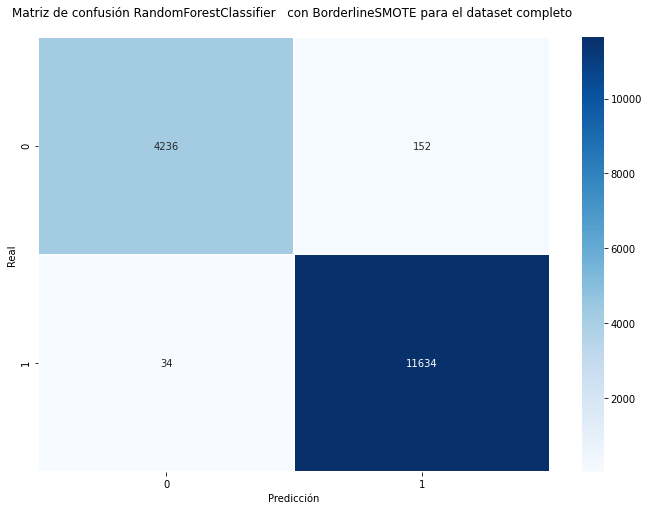

In [71]:
matrixDTC_F = confusion_matrix(y,y_predRFC_probab)
dataframe = pd.DataFrame(matrixDTC_F)
plt.figure(figsize = (10,7))
sns.heatmap(dataframe,
            annot = True,
            cbar = True,
            linewidths=0.1,
            fmt=".0f", 
            cmap="Blues"
            )
plt.title("Matriz de confusión RandomForestClassifier   con BorderlineSMOTE para el dataset completo \n"), plt.tight_layout()
plt.ylabel("Real"), plt.xlabel("Predicción")
plt.show()

In [74]:
y_predRFC_probab = pd.DataFrame(y_predRFC_probab)
y_predRFC_probabilidades = pd.DataFrame(y_predRFC_probabilidades)
y_predRFC_probab.to_excel("Predicciones_RFC_Para_Septiembre.xlsx")
y_predRFC_probabilidades.to_excel("Probabilidades_RFC_Para_Septiembre.xlsx")
#Probabilidades de compra general para el RandomForestClassifier
basePredichaParaSeptiembre = pd.read_excel("/content/Predicciones_RFC_Para_Septiembre.xlsx", index_col=0)
#Acá generamos la base que tiene la predicción de compra para los clientes de Septiembre

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fecf9664050>]],
      dtype=object)

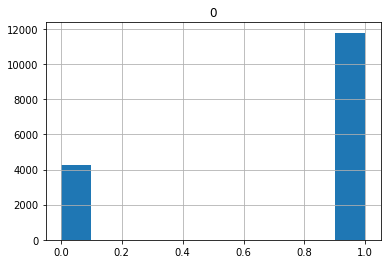

In [75]:
y_predRFC_probab.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fecf96644d0>,
      dtype=object)

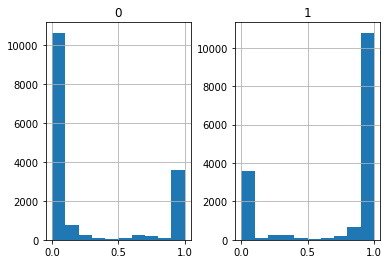

In [76]:
y_predRFC_probabilidades.hist()

In [77]:
baseUsuariosTotales = pd.DataFrame(baseHist['Cliente'].unique())
baseUsuariosTotales.columns = ['Cliente']
baseUsuariosTotales.head()

,Cliente
0,10
1,12
2,14
3,15
4,18


In [78]:
baseUsuariosTotales.count()

Cliente    16056
dtype: int64

________
Vamos a sacar la base de los que si efectivamente compraron en Septiembre, es decir, los verdaderos verdaderos. (True Positive)
________

In [54]:
baseUsuariosQueSiCompraronDeVerdad = pd.DataFrame(baseSeptiembre['Cliente'].unique())
baseUsuariosQueSiCompraronDeVerdad.columns = ['Cliente']
baseUsuariosQueSiCompraronDeVerdad.count()

Cliente    13664
dtype: int64

In [55]:
baseUsuariosQueSiCompraronDeVerdad
baseUsuariosQueSiCompraronDeVerdad["Real"] = 1

In [56]:
baseUsuariosQueSiCompraronDeVerdad

,Cliente,Real
0,10,1
1,12,1
2,14,1
3,15,1
4,18,1
...,...,...
13659,20360,1
13660,20405,1
13661,20414,1
13662,20456,1


In [57]:
BaseResultadosSeptiembre = baseGetDummies.merge(basePredichaParaSeptiembre, how='outer', left_index=True, right_index=True)
BaseResultadosSeptiembre.columns = ["Cliente","Recencia","RecenciaCluster","Frecuencia","FrecuenciaCluster","Monetizacion","MonetizacionCluster","ScoreGeneral","DiasTransc","DiasTransc2","DiasTransc3","DiasTransc4","DiasTranscMean","DiasTranscStd","Segmento_Valor-Alto","Segmento_Valor-Bajo","Segmento_Valor-Medio","RangoDiasSigCompra","Prediccion"] 
BaseResultadosSeptiembre = BaseResultadosSeptiembre[[ 'Cliente','Prediccion' ]]
BaseResultadosSeptiembre

,Cliente,Prediccion
0,10,1
1,24,1
2,26,1
3,33,1
4,57,1
...,...,...
16051,5788,1
16052,9794,1
16053,13069,1
16054,14357,1


In [58]:
baseUsuariosQueSiCompraronDeVerdad.Real.value_counts()

1    13664
Name: Real, dtype: int64

In [59]:
BaseResultadosSeptiembre.Prediccion.value_counts()

1    11786
0     4270
Name: Prediccion, dtype: int64

In [60]:
#Hacemos un Inner Join para determinar los que si están entre los dos 
#baseResultados = baseUsuariosQueSiCompraronDeVerdad.merge(BaseResultadosSeptiembre, on="Cliente", how='left')
#baseResultados = baseUsuariosQueSiCompraronDeVerdad.merge(BaseResultadosSeptiembre, on="Cliente", how='right')
baseResultados = pd.merge(BaseResultadosSeptiembre,baseUsuariosQueSiCompraronDeVerdad,on='Cliente')
#Acá nos encargamos de cambiar los NaN por 0
baseResultados = baseResultados.fillna(0)

#Cambiamos de doble a entero:
baseResultados["Prediccion"] = baseResultados[["Prediccion"]].astype(int)
baseResultados["Real"] = baseResultados[["Real"]].astype(int)

baseResultados
baseResultados.to_excel("Resultados.xlsx")

In [61]:
BasePruebasClientes = baseFechasCompra_last[baseFechasCompra_last.Cliente.eq(20580)]
BasePruebasClientes

,Cliente,Fecha,diaCompra,MesCompra_1,MesCompra_2,MesCompra_3,MesCompra_4,DiasTransc,DiasTransc2,DiasTransc3,DiasTransc4,DiasTranscMean,DiasTranscStd
16055,20580,2020-07-01,2020-07-01,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
baseResultados.Prediccion.value_counts()

1    11060
0     1748
Name: Prediccion, dtype: int64

In [63]:
baseResultados.Real.value_counts()

1    12808
Name: Real, dtype: int64

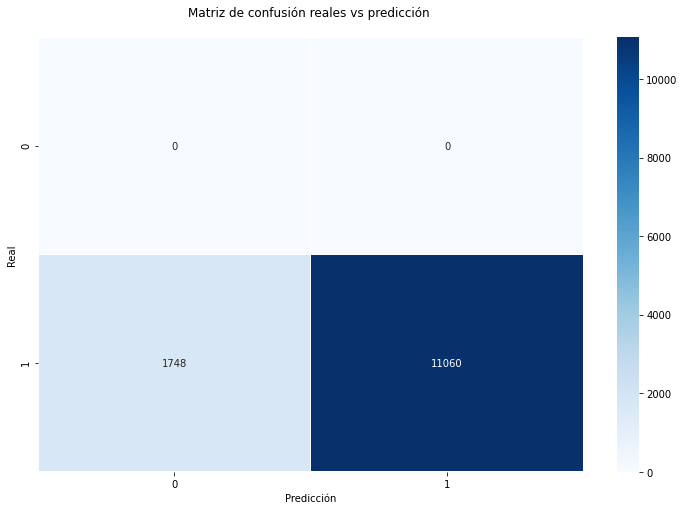

In [64]:
matrixPrediccion = confusion_matrix(baseResultados[["Real"]],baseResultados[["Prediccion"]])
dataframe = pd.DataFrame(matrixPrediccion)
plt.figure(figsize = (10,7))
sns.heatmap(dataframe,
            annot = True,
            cbar = True,
            linewidths=0.1,
            fmt=".0f", 
            cmap="Blues"
            )
plt.title("Matriz de confusión reales vs predicción \n"), plt.tight_layout()
plt.ylabel("Real"), plt.xlabel("Predicción")
plt.show()

In [65]:
print('\n Métricas para datos reales vs predichos para el mes de Septiembre :\n\n')
print(classification_report(y_true=baseResultados[["Real"]],y_pred=baseResultados[["Prediccion"]]))


 Métricas para datos reales vs predichos para el mes de Septiembre :


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.86      0.93     12808

    accuracy                           0.86     12808
   macro avg       0.50      0.43      0.46     12808
weighted avg       1.00      0.86      0.93     12808



* Acá evidenciamos el score general y el accuracy del modelo para los datos de Septiembre, los cuales no era conocidos por el modelo